## MA 544 Spring 2021: Programming Assignment - 4
---


In [47]:
import os
import PIL
import numpy as np
from glob import glob
import matplotlib.pyplot as pt
from typing import Iterable, List
from sklearn.decomposition import NMF

### Question 1
---
Find the nonnegative basis representation of images from one of the following databases. Show a comparison of some sample images with their reconstruction from the basis.

>- The ORL database of faces at [ORL link](http://cam-orl.co.uk/facedatabase.html/#:~:text=Our%20Database%20of%20Faces%2C%20%28formerly%20%27The%20ORL%20Database,Robotics%20Group%20of%20the%20Cambridge%20University%20Engineering%20Department.).

>- The CBCL database of faces at [MIT link](http://cbcl.mit.edu/software-datasets/heisele/facerecognition-database.html).

>- Yale faces B facial images at [UCSD](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html).

In [48]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [49]:
# to avoid having to write code to fully parse the data by subject I 
# will write it to handle a single subject, yaleB01
data_folder: str = os.path.join('data', 'CroppedYale', 'yaleB01')

In [50]:
class PGMReader():
    def __init__(self, filepath, mode):
        assert filepath.split('.')[-1] == 'pgm'
        self.filepath = filepath
        self.mode = mode
        
    def __enter__(self):
        # return the file object after opening and setting it up
        self.pgm_image = open(self.filepath, self.mode)
        return self.read_pgm(self.pgm_image)
    
    def __exit__(self, type, value, traceback):
        self.pgm_image.close()
    
    def read_pgm(self, pgmf):
        """Return a raster of integers from a PGM as a list of lists."""
        assert pgmf.readline() == b'P5\n'
        (width, height) = [int(i) for i in pgmf.readline().split()]
        depth = int(pgmf.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(pgmf.read(1)))
            raster.append(row)
        return np.array(raster)

Shape of images: (192, 168)


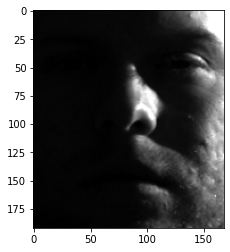

In [69]:
m, n = 192, 168
images = np.zeros((m*n, len(filepaths)))
for i, filepath in enumerate(filepaths):
    with PGMReader(filepath, 'rb') as image:
        images[:, i] = image.reshape((m*n,))
        
print(f"Shape of images: ({m}, {n})")
pt.imshow(images[:, 2].reshape((m, n)), cmap='gray')

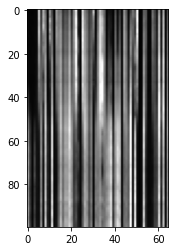

In [71]:
pt.imshow(images[:100, :], cmap='gray')

In [73]:
model = NMF(init='random', random_state=42)

In [74]:
W = model.fit_transform(images)
H = model.components_

/home/mycicle/anaconda3/envs/cs583/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [75]:
W

array([[ 0.        ,  7.0667108 ,  0.01360707, ...,  0.        ,
         8.70197451,  0.        ],
       [ 1.80391335,  9.55500078,  0.        , ...,  0.        ,
         9.30555694,  0.11925356],
       [ 2.9402273 , 10.51128609,  0.        , ...,  0.37315264,
         8.18572532,  0.34654001],
       ...,
       [ 0.        ,  0.        ,  0.52862418, ...,  0.        ,
         0.15757623,  0.        ],
       [ 0.        ,  0.        ,  0.89920459, ...,  0.        ,
         0.144448  ,  0.        ],
       [ 0.        ,  0.        ,  1.13999519, ...,  0.        ,
         0.25239468,  0.        ]])

In [76]:
H

array([[0.00000000e+00, 0.00000000e+00, 2.07773219e-02, ...,
        8.78664126e-01, 0.00000000e+00, 1.57723027e+00],
       [0.00000000e+00, 0.00000000e+00, 4.80125617e-03, ...,
        1.85766609e+00, 0.00000000e+00, 1.37925508e+00],
       [1.11387078e+01, 5.09610298e+00, 6.78951486e-02, ...,
        3.09030675e-02, 0.00000000e+00, 2.22455029e-01],
       ...,
       [5.73592151e-01, 2.43350287e-01, 2.16502390e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.33542958e+00],
       [0.00000000e+00, 0.00000000e+00, 1.03499103e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.26360691e-01],
       [0.00000000e+00, 0.00000000e+00, 1.24697630e-01, ...,
        1.08046755e+00, 0.00000000e+00, 0.00000000e+00]])

In [77]:
W.shape

(32256, 65)

In [78]:
H.shape

(65, 65)

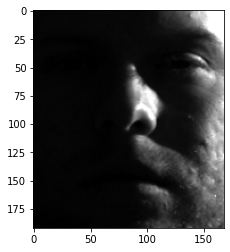

In [92]:
# original image 2
pt.imshow(images[:, 2].reshape(m, n), cmap='gray')

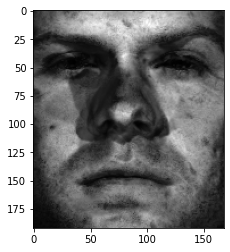

In [91]:
# reconstruction of image 2
combinations = H[2, :]
reconstruction = W @ combinations
pt.imshow(reconstruction.reshape(m, n), cmap='gray')

### Question 2
---
Set up a linear regression model for the miles per gallon on the data at automobile [UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/).  Discard the categorical data.

>1. Analyze the data to get relevant insight.
>1. Get feature matrix X, and target variable y.
>1. Split data into training and testing.
>1. Normalize data using MinMaxScaler.
>1. Creat a LinearRegression object for modeling.
>1. Train the model with training data.
>1. Look at R^2 score for the goodness of fit for the train and test data.
>1. Present a graphical comparison of true and observed responses for the test data.
>1. Improve the performance of your model on the test data.

In [ ]:
# Your code comes here


### Question 3
---
Setup a logistic regression model on the data at [adultUCI](http://archive.ics.uci.edu/ml/datasets/Adult).  Discuss the performance of your model using appropriate statistics. Use dummy variables to handle categorical variables. 

>1. Prepare the data. Create dummy variables for categorical variables. [See this](https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)
>1. Analyze the data to get relevant insight.
>2. Get feature matrix X, and target variable y (>50k or <50k)
>3. Split data into training and testing
>4. Normalize data using MinMaxScaler
>5. Creat a LogisticRegression object for modeling
>6. Train the model with training data
>7. Compare the precision, recall, and F1-score on the train and test data.
>1. Improve the performance of your model on the test data.

In [ ]:
# Your code comes here